This code is used to identify cruises to withhold for the hackathon. We will find cruises with DIC data. DIC and TAlk are sampled the least so if we find cruises that work for DIC, they should work for the other variables. We will find the cruise we want in the bottles, and then use those dates to find the same cruise int he ctd data. 
1. load in the bottle data and identify poorly sampled months for DIC
2. 

In [1]:
import pandas as pd
import numpy as np
import calendar

In [2]:

# Read the CSV file
df = pd.read_csv('/home/amh001/work_fs7/DATA/LINEP/LineP_for_Data_Synthesis_1990-2019_v1.csv')

# Count unique cruises with valid DIC data 
# (not NaN, not -999, and flag 2)
cruises_with_dic = df[
    (df['DIC_UMOL_KG'].notna()) &  # Remove NaN 
    (df['DIC_UMOL_KG'] != -999) &  # Remove -999
    (
        # Either pressure is valid
        ((df['CTDPRS_DBAR'].notna()) & (df['CTDPRS_DBAR'] != -999)) |
        # Or depth is valid
        ((df['DEPTH_METER'].notna()) & (df['DEPTH_METER'] != -999))
    ) &
    (df['DIC_FLAG_W'] == 2)  # Ensure flag is 2
]['CRUISE_ID'].nunique()

print(f"Number of unique cruises with valid DIC data: {cruises_with_dic}")

# Optional: Additional details
total_dic_measurements = df[
    (df['DIC_UMOL_KG'].notna()) &  # Remove NaN 
    (df['DIC_UMOL_KG'] != -999) &  # Remove -999
    (
        # Either pressure is valid
        ((df['CTDPRS_DBAR'].notna()) & (df['CTDPRS_DBAR'] != -999)) |
        # Or depth is valid
        ((df['DEPTH_METER'].notna()) & (df['DEPTH_METER'] != -999))
    ) &
    (df['DIC_FLAG_W'] == 2)  # Ensure flag is 2
].shape[0]
print(f"Total number of valid DIC measurements: {total_dic_measurements}")

# Optional: Check depth and pressure availability
print("\nDepth and Pressure Availability:")
print("Rows with valid pressure:", 
      ((df['CTDPRS_DBAR'].notna()) & (df['CTDPRS_DBAR'] != -999)).sum())
print("Rows with valid depth:", 
      ((df['DEPTH_METER'].notna()) & (df['DEPTH_METER'] != -999)).sum())

Number of unique cruises with valid DIC data: 55
Total number of valid DIC measurements: 4264

Depth and Pressure Availability:
Rows with valid pressure: 4539
Rows with valid depth: 444


Month Sampling Summary:
     Samples  Percentage
Feb     1670       39.17
Mar      138        3.24
May      315        7.39
Jun      959       22.49
Aug      740       17.35
Sep      429       10.06
Oct       13        0.30

Months with no samples:
['Jan', 'Apr', 'Jul', 'Nov', 'Dec']


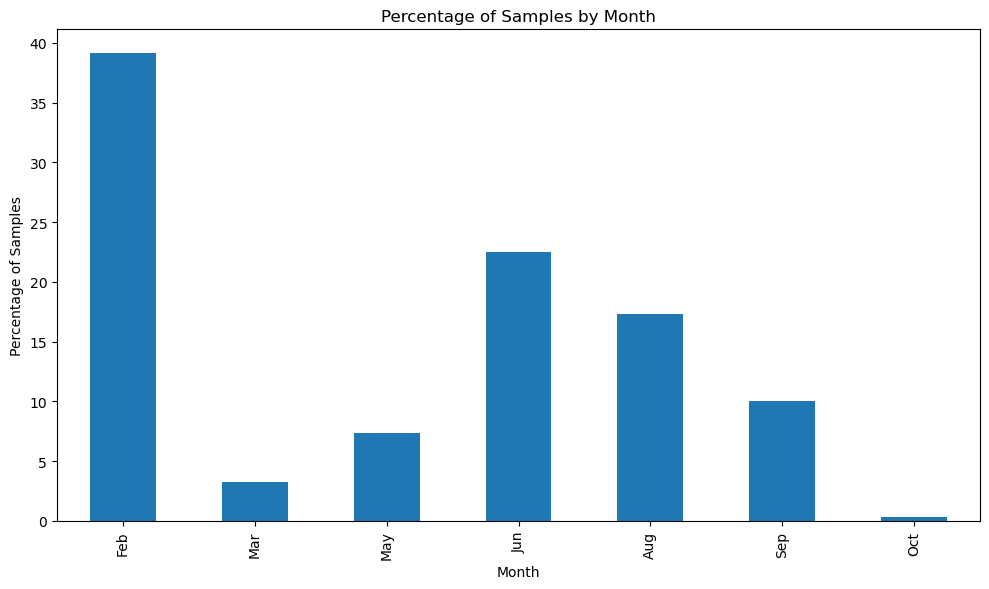

In [3]:


# Filter for valid DIC measurements first
valid_df = df[
    (df['DIC_UMOL_KG'].notna()) &  # Remove NaN 
    (df['DIC_UMOL_KG'] != -999) &  # Remove -999
    (df['DIC_FLAG_W'] == 2) &  # Ensure flag is 2
    (
        # Either pressure is valid
        ((df['CTDPRS_DBAR'].notna()) & (df['CTDPRS_DBAR'] != -999)) |
        # Or depth is valid
        ((df['DEPTH_METER'].notna()) & (df['DEPTH_METER'] != -999))
    )
]

# Count occurrences of each month
month_counts = valid_df['MONTH_UTC'].value_counts().sort_index()

# Calculate total samples
total_samples = month_counts.sum()

# Calculate percentage of samples for each month
month_percentages = (month_counts / total_samples * 100).round(2)

# Create a comprehensive month summary
month_summary = pd.DataFrame({
    'Samples': month_counts,
    'Percentage': month_percentages
})

# Add month names
month_summary.index = [calendar.month_abbr[m] for m in month_summary.index]

# Print detailed month summary
print("Month Sampling Summary:")
print(month_summary)

# Identify months with no samples
all_months = set(range(1, 13))
sampled_months = set(valid_df['MONTH_UTC'].unique())
unsampled_months = all_months - sampled_months

print("\nMonths with no samples:")
print([calendar.month_abbr[m] for m in unsampled_months])

# Optional: Visualize month distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
month_summary['Percentage'].plot(kind='bar')
plt.title('Percentage of Samples by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Samples')
plt.tight_layout()
plt.show()
#plt.savefig(f'Figures/Cruise_data_{chosen_cruise}.png', format='png',bbox_inches='tight',transparent=False,dpi=800)


In [4]:

# Diagnostic print for initial data
print("Total rows in dataset:", len(df))
print("\nDIC_UMOL_KG info:")
print(df['DIC_UMOL_KG'].describe())
print("\nUnique DIC_FLAG_W values:", df['DIC_FLAG_W'].unique())
print("\nPressure (CTDPRS_DBAR) info:")
print(df['CTDPRS_DBAR'].describe())
print("\nDepth (DEPTH_METER) info:")
print(df['DEPTH_METER'].describe())



# Diagnostic print for filtered data
print("\nValid DIC measurements:")
print("Total rows after filtering:", len(valid_df))
print("Unique cruises:", valid_df['CRUISE_ID'].nunique())

# Group by cruise and get unique months for valid data
cruise_months = valid_df.groupby('CRUISE_ID')['MONTH_UTC'].unique()

#entering from above plot
typical_months = [2, 6, 8,]  # 

unusual_month_cruises = cruise_months[
    cruise_months.apply(lambda x: any(month not in typical_months for month in x))
]

# Print out unusual month cruises
print("\nCruises with data in unusual months:")
for cruise, months in unusual_month_cruises.items():
    print(f"Cruise {cruise}: Months {months}")




Total rows in dataset: 4983

DIC_UMOL_KG info:
count    4983.000000
mean     1988.537849
std       871.123454
min      -999.000000
25%      2040.550000
50%      2258.800000
75%      2362.450000
max      2582.900000
Name: DIC_UMOL_KG, dtype: float64

Unique DIC_FLAG_W values: [ 2  9  3  6  4 36 63]

Pressure (CTDPRS_DBAR) info:
count    4983.000000
mean      804.888120
std      1234.966119
min      -999.000000
25%        74.250000
50%       299.900000
75%      1319.750000
max      4325.800000
Name: CTDPRS_DBAR, dtype: float64

Depth (DEPTH_METER) info:
count    4983.000000
mean     -820.563315
std       688.055092
min      -999.000000
25%      -999.000000
50%      -999.000000
75%      -999.000000
max      4282.000000
Name: DEPTH_METER, dtype: float64

Valid DIC measurements:
Total rows after filtering: 4264
Unique cruises: 55

Cruises with data in unusual months:
Cruise 1990.01: Months [5]
Cruise 1990.02: Months [8 9]
Cruise 1991.15: Months [10]
Cruise 1992.15: Months [9]
Cruise 1993.03


Enter the cruise ID you want to plot:  2006.15



Cruise data after filtering:
Total rows: 91
Rows with valid pressure: 91
Rows with valid depth: 0

Cruise 2006.15 details:
Number of unique stations: 4
Stations: [12 16 20 26]


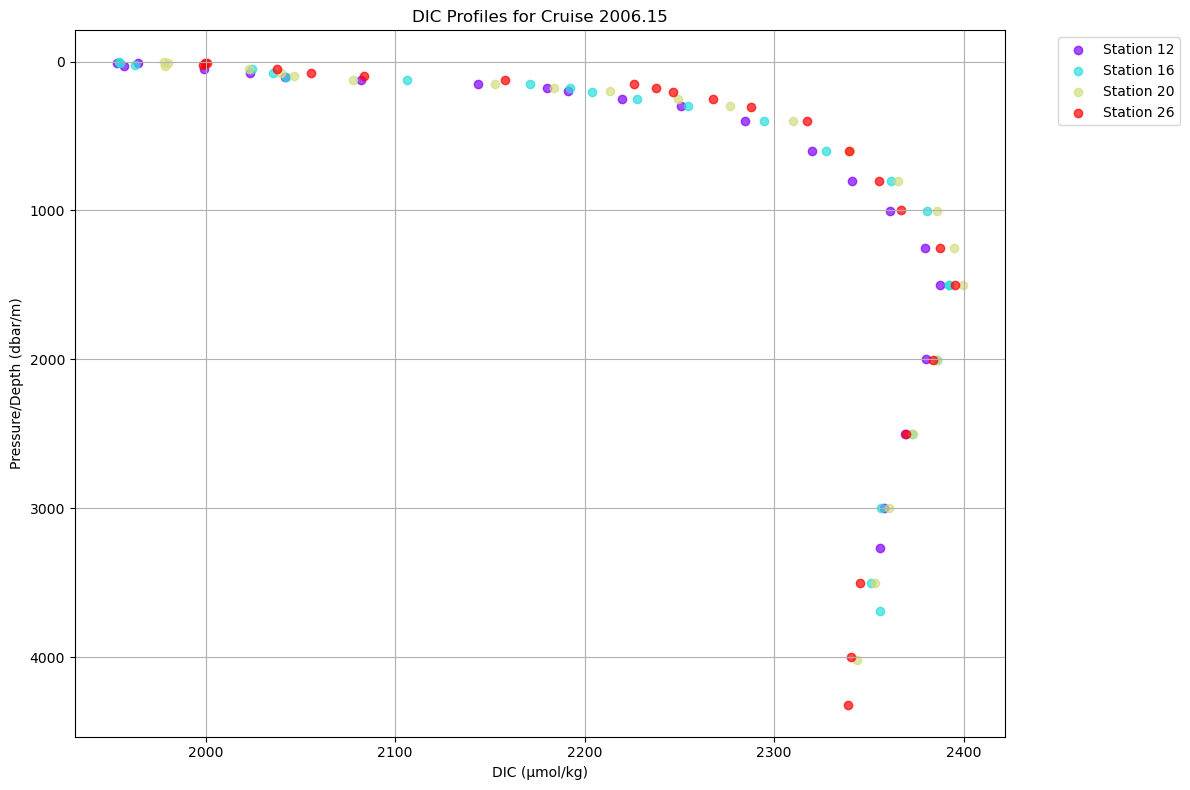

In [23]:
# Prompt user to choose a cruise
chosen_cruise = float(input("\nEnter the cruise ID you want to plot: "))

# Filter data for the chosen cruise with valid DIC measurements
cruise_data = df[
    (df['CRUISE_ID'] == chosen_cruise) &  # Specific cruise
    (df['DIC_UMOL_KG'].notna()) &  # Remove NaN 
    (df['DIC_UMOL_KG'] != -999) &  # Remove -999
    (df['DIC_FLAG_W'] == 2)  # Ensure flag is 2
]

# Further filter out -999 values for depth and pressure
cruise_data = cruise_data[
    ((cruise_data['CTDPRS_DBAR'].notna()) & (cruise_data['CTDPRS_DBAR'] != -999)) |
    ((cruise_data['DEPTH_METER'].notna()) & (cruise_data['DEPTH_METER'] != -999))
]

# Diagnostic print to check filtering
print("\nCruise data after filtering:")
print("Total rows:", len(cruise_data))
print("Rows with valid pressure:", len(cruise_data[cruise_data['CTDPRS_DBAR'] != -999]))
print("Rows with valid depth:", len(cruise_data[cruise_data['DEPTH_METER'] != -999]))

# Get unique stations
unique_stations = cruise_data['STATION_ID'].unique()

# Print station information
print(f"\nCruise {chosen_cruise} details:")
print(f"Number of unique stations: {len(unique_stations)}")
print("Stations:", unique_stations)

# Create the plot
plt.figure(figsize=(12, 8))

# Use a colormap to generate distinct colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stations)))

# Plot each station's profile
for i, station in enumerate(unique_stations):
    station_data = cruise_data[cruise_data['STATION_ID'] == station]
    
    # Use pressure if available, otherwise use depth
    vertical_coordinate = 'CTDPRS_DBAR' if (station_data['CTDPRS_DBAR'] != -999).any() else 'DEPTH_METER'
    
    plt.scatter(station_data['DIC_UMOL_KG'], station_data[vertical_coordinate], 
                label=f'Station {station}', color=colors[i], alpha=0.7)

plt.xlabel('DIC (μmol/kg)')
plt.ylabel('Pressure/Depth (dbar/m)')
plt.title(f'DIC Profiles for Cruise {chosen_cruise}')
plt.gca().invert_yaxis()  # Invert y-axis to show depth correctly
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig(f'Figures/Cruise_data_{chosen_cruise}.png', format='png', bbox_inches='tight', transparent=False, dpi=800)

plt.show()


Data Coverage Analysis:
Total valid DIC measurements across all cruises: 4264
Measurements in cruise 2006.15: 91
Percentage of total data: 2.13%

Yearly Measurement Breakdown:
YEAR_UTC
1990    224
1991     13
1992    249
1993    102
1994    141
1995     43
1996    146
1997    107
1998     23
1999    137
2000     44
2001    179
2002     60
2003    207
2004    324
2005    106
2006    195
2007    301
2008    302
2010    188
2013     87
2014    102
2015    215
2016    314
2017    200
2018     89
2019    166
dtype: int64


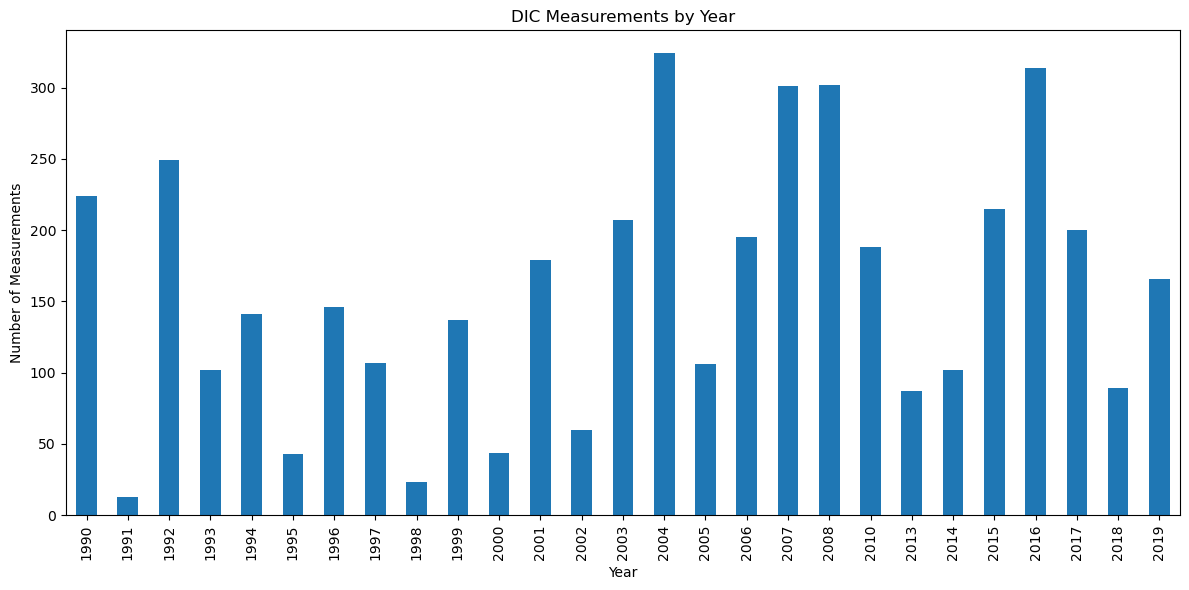

In [24]:
# Calculate total data across all cruises
total_dic_measurements = df[
    (df['DIC_UMOL_KG'].notna()) &  # Remove NaN 
    (df['DIC_UMOL_KG'] != -999) &  # Remove -999
    (df['DIC_FLAG_W'] == 2)  # Ensure flag is 2
]

# Calculate measurements for the current cruise
current_cruise_measurements = df[
    (df['CRUISE_ID'] == chosen_cruise) &
    (df['DIC_UMOL_KG'].notna()) &  # Remove NaN 
    (df['DIC_UMOL_KG'] != -999) &  # Remove -999
    (df['DIC_FLAG_W'] == 2)  # Ensure flag is 2
]

# Calculate percentages
total_measurements = len(total_dic_measurements)
cruise_measurements = len(current_cruise_measurements)
percentage_of_total = (cruise_measurements / total_measurements) * 100

print("\nData Coverage Analysis:")
print(f"Total valid DIC measurements across all cruises: {total_measurements}")
print(f"Measurements in cruise {chosen_cruise}: {cruise_measurements}")
print(f"Percentage of total data: {percentage_of_total:.2f}%")

# Optional: Breakdown by year
yearly_breakdown = total_dic_measurements.groupby('YEAR_UTC').size()
print("\nYearly Measurement Breakdown:")
print(yearly_breakdown)

# Optional: Visualize yearly distribution
plt.figure(figsize=(12, 6))
yearly_breakdown.plot(kind='bar')
plt.title('DIC Measurements by Year')
plt.xlabel('Year')
plt.ylabel('Number of Measurements')
plt.tight_layout()
plt.show()

notes on analysis 

1991.15 only has P26 <br>
1996.09 has 4 stations and is sampled in may<br>
2006.15 - 4 stations and sampled in sept. <br>
2003.27 - 5 stations and sampled in sept. <br>
2018.01 - 5 stations and sampled in march - 2.09% of total data

# Finding a particular cruise int he ctd data. 

In [16]:
import pandas as pd
import numpy as np
from datetime import timedelta
import glob
import os

# Find all CTD files
ctd_files = glob.glob('/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/SD-Ocean/Training/observations/binned/LineP_ctds_*_binned_1m.csv')

# Read and concatenate all CTD files
ctd_dfs = []
for file in ctd_files:
    df_ctd = pd.read_csv(file, parse_dates=['time'])
    ctd_dfs.append(df_ctd)

ctd_df = pd.concat(ctd_dfs, ignore_index=True)




In [17]:
ctd_df.keys()

Index(['time', 'file', 'CTDPRS_DBAR', 'CTDTMP_ITS90_DEG_C', 'SALINITY_PSS78',
       'latitude', 'longitude', 'OXYGEN_MMOL_M3', 'OXYGEN_UMOL_KG',
       'closest_linep_station_name', 'distance_to_closest_station_km',
       'PRS_bin_cntr'],
      dtype='object')

In [25]:
# Filter bottle data for the chosen cruise
bottle_cruise_data = df[df['CRUISE_ID'] == chosen_cruise]

# Calculate cruise start and end dates
bottle_cruise_data['DATE_UTC'] = pd.to_datetime(
    bottle_cruise_data['YEAR_UTC'].astype(str) + '-' + 
    bottle_cruise_data['MONTH_UTC'].astype(str).str.zfill(2) + '-' + 
    bottle_cruise_data['DAY_UTC'].astype(str).str.zfill(2)
)

cruise_start_date = bottle_cruise_data['DATE_UTC'].min()
cruise_end_date = bottle_cruise_data['DATE_UTC'].max()

# Create single window encompassing entire date range
window_min = cruise_start_date - timedelta(days=5)
window_max = cruise_end_date + timedelta(days=5)

print(f"\nCruise original date range: {cruise_start_date} to {cruise_end_date}")
print(f"Extended window: {window_min} to {window_max}")

# Filter CTD data within the single window
ctd_cruise_data = ctd_df[
    (pd.to_datetime(ctd_df['time']) >= window_min) & 
    (pd.to_datetime(ctd_df['time']) <= window_max)
]

# Optional: Narrow down by stations
bottle_stations = bottle_cruise_data['STATION_ID'].unique()
print("\nStations in bottle data:", bottle_stations)

# Check matching CTD stations
matching_ctd_stations = ctd_cruise_data['closest_linep_station_name'].unique()
print("Matching CTD stations:", matching_ctd_stations)

# Define CTD variables to analyze
ctd_variables = [
    'CTDPRS_DBAR', 
    'CTDTMP_ITS90_DEG_C', 
    'SALINITY_PSS78', 
    'OXYGEN_UMOL_KG'
]

# Optional: More detailed matching
print("\nDetailed CTD data for matching stations:")
for station in matching_ctd_stations:
    station_ctd_data = ctd_cruise_data[ctd_cruise_data['closest_linep_station_name'] == station]
    
    # Count unique profiles (files)
    unique_profiles = station_ctd_data['file'].unique()
    
    print(f"\nStation {station}:")
    print("Unique dates:", station_ctd_data['time'].unique())
    print("Number of unique CTD profiles:", len(unique_profiles))
    print("Total CTD samples:", len(station_ctd_data))
    


/tmp/amh001/1165/ipykernel_1831/28342411.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottle_cruise_data['DATE_UTC'] = pd.to_datetime(



Cruise original date range: 2006-09-23 00:00:00 to 2006-09-28 00:00:00
Extended window: 2006-09-18 00:00:00 to 2006-10-03 00:00:00

Stations in bottle data: [12 16 20 26]
Matching CTD stations: ['P18' 'P5' 'P3' 'P26' 'P21' 'P14' 'P4' 'P16' 'P25' 'P12' 'P17' 'P20'
 'P19' 'P7' 'P9' 'P11' 'P6' 'P10' 'P35' 'P13' 'P24' 'P23' 'P22' 'P15' 'P8'
 'P2']

Detailed CTD data for matching stations:

Station P18:
Unique dates: [Timestamp('2006-09-25 13:47:13')]
Number of unique CTD profiles: 1
Total CTD samples: 2005

Station P5:
Unique dates: [Timestamp('2006-09-22 08:10:50')]
Number of unique CTD profiles: 1
Total CTD samples: 2000

Station P3:
Unique dates: [Timestamp('2006-09-21 18:15:50')]
Number of unique CTD profiles: 1
Total CTD samples: 792

Station P26:
Unique dates: [Timestamp('2006-09-28 21:20:20') Timestamp('2006-09-29 03:19:52')
 Timestamp('2006-09-28 10:30:08') Timestamp('2006-09-29 12:10:30')
 Timestamp('2006-09-28 15:20:52')]
Number of unique CTD profiles: 5
Total CTD samples: 8760


chosen_cruise 2006.15

Total CTD Measurements Across All Data:
CTDPRS_DBAR: 6961569
CTDTMP_ITS90_DEG_C: 6956450
SALINITY_PSS78: 6920489
OXYGEN_UMOL_KG: 3113908
OXYGEN_MMOL_M3: 3438588

CTD Measurements in Current Cruise Window:
CTDPRS_DBAR: 68242 (0.98% of total)
CTDTMP_ITS90_DEG_C: 68242 (0.98% of total)
SALINITY_PSS78: 68239 (0.99% of total)
OXYGEN_UMOL_KG: 67250 (2.16% of total)
OXYGEN_MMOL_M3: 67253 (1.96% of total)

Yearly CTD Measurement Breakdown:


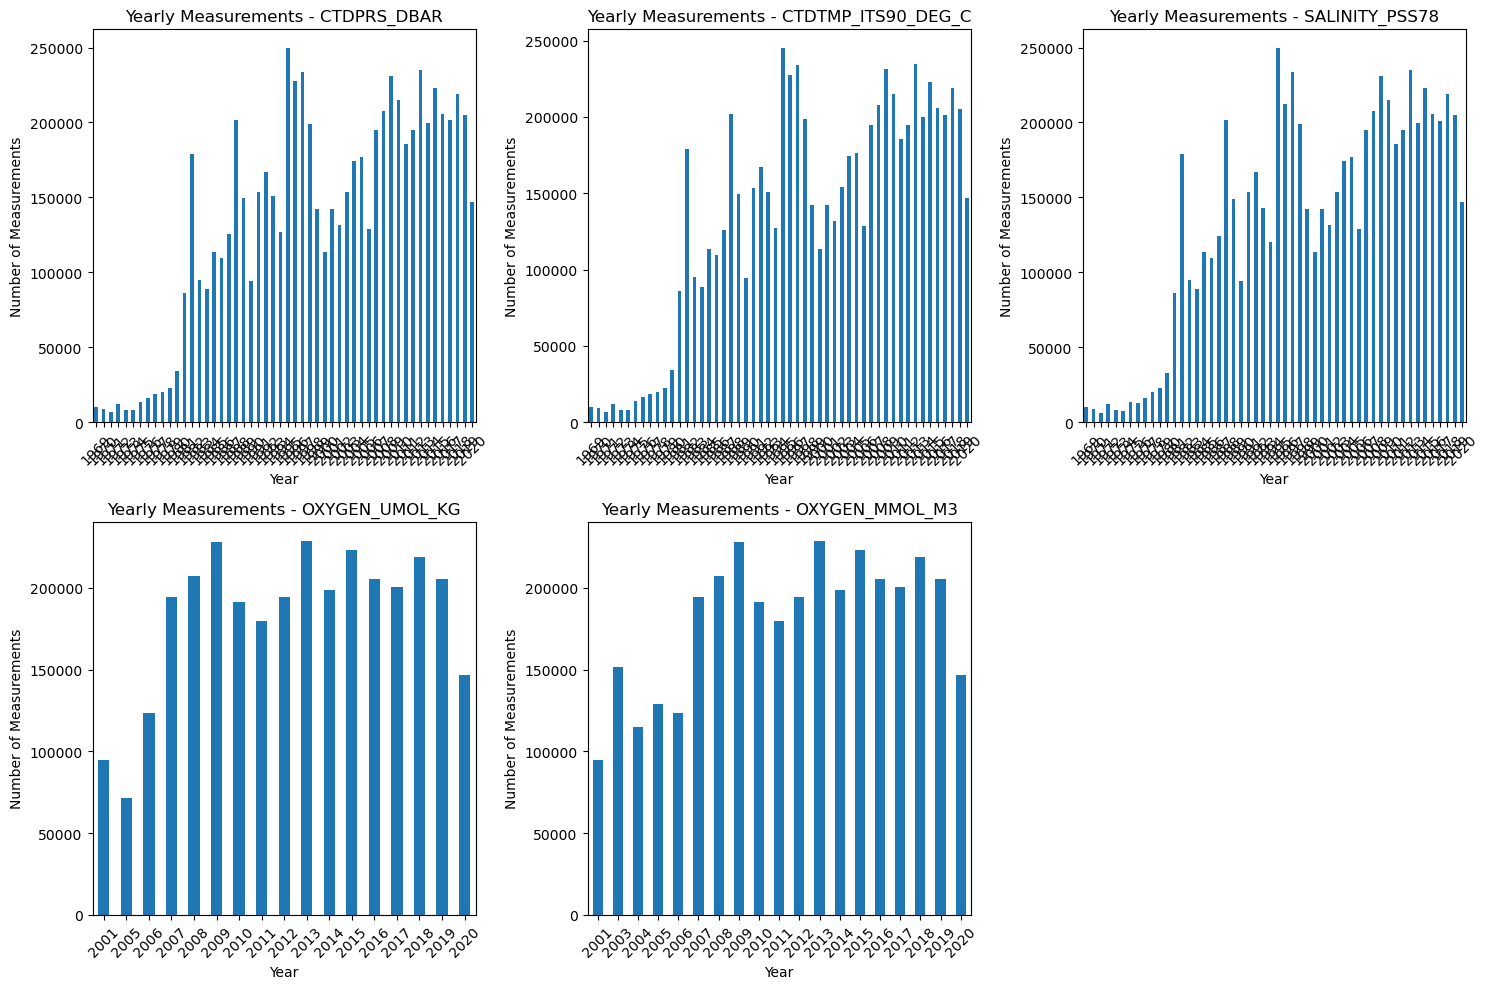


Station Breakdown for Cruise Window:
                            file  time
closest_linep_station_name            
P10                            1     1
P11                            1     1
P12                            2     2
P13                            1     1
P14                            1     1
P15                            1     1
P16                            3     3
P17                            1     1
P18                            1     1
P19                            1     1
P2                             1     1
P20                            3     3
P21                            1     1
P22                            1     1
P23                            1     1
P24                            1     1
P25                            1     1
P26                            5     5
P3                             1     1
P35                            1     1
P4                             2     2
P5                             1     1
P6                        

In [26]:

print('chosen_cruise', chosen_cruise)
# Create a single date column for CTD data
ctd_df['DATE'] = pd.to_datetime(ctd_df['time']).dt.date

# Variables to analyze
ctd_variables = [
    'CTDPRS_DBAR', 
    'CTDTMP_ITS90_DEG_C', 
    'SALINITY_PSS78', 
    'OXYGEN_UMOL_KG',
    'OXYGEN_MMOL_M3'
]

# Filter CTD data for the chosen cruise window
ctd_cruise_data = ctd_df[
    (pd.to_datetime(ctd_df['time']) >= window_min) & 
    (pd.to_datetime(ctd_df['time']) <= window_max)
]

# Calculate total CTD data across all times
def count_valid_measurements(df, column):
    return df[df[column].notna() & (df[column] != -999)].shape[0]

# Total measurements for each variable
print("\nTotal CTD Measurements Across All Data:")
for var in ctd_variables:
    total_measurements = count_valid_measurements(ctd_df, var)
    print(f"{var}: {total_measurements}")

# Measurements for the current cruise window
print("\nCTD Measurements in Current Cruise Window:")
for var in ctd_variables:
    window_measurements = count_valid_measurements(ctd_cruise_data, var)
    total_measurements = count_valid_measurements(ctd_df, var)
    percentage = (window_measurements / total_measurements) * 100
    print(f"{var}: {window_measurements} ({percentage:.2f}% of total)")

# Yearly breakdown of CTD data
print("\nYearly CTD Measurement Breakdown:")
# Extract year from time column
ctd_df['YEAR'] = pd.to_datetime(ctd_df['time']).dt.year

# Count unique files (profiles) per year for each variable
yearly_breakdown = {}
for var in ctd_variables:
    # Count non-NaN, non-999 measurements per year
    yearly_var_breakdown = ctd_df[
        ctd_df[var].notna() & (ctd_df[var] != -999)
    ].groupby('YEAR').size()
    yearly_breakdown[var] = yearly_var_breakdown

# Visualize yearly breakdown
plt.figure(figsize=(15, 10))
for i, (var, data) in enumerate(yearly_breakdown.items(), 1):
    plt.subplot(2, 3, i)
    data.plot(kind='bar')
    plt.title(f'Yearly Measurements - {var}')
    plt.xlabel('Year')
    plt.ylabel('Number of Measurements')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Optional: Detailed station breakdown for the cruise window
print("\nStation Breakdown for Cruise Window:")
station_breakdown = ctd_cruise_data.groupby('closest_linep_station_name').agg({
    'file': 'nunique',  # number of unique profiles
    'time': 'nunique'   # number of unique dates
})
print(station_breakdown)

2003.27 only has umol/kg ?? <br>
Choose 2018.01 and 2006.15